In [1]:
# All the required imports

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
from skimage import io, transform
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

%matplotlib inline 

In [2]:
# Exploring train.csv file
df = pd.read_csv('../input/train.csv')
df.head()

,Category,Id
0,41,zwnluz.jpg
1,6,ptsbsg.jpg
2,15,txhnvq.jpg
3,18,bulncb.jpg
4,18,tkvqyc.jpg


In [3]:
#Dataset class

class ImageDataset(Dataset):
    

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame['Id'][idx])         # getting path of image
        image = Image.open(img_name).convert('RGB')                                # reading image and converting to rgb if it is grayscale
        label = np.array(self.data_frame['Category'][idx])                         # reading label of the image
        
        if self.transform:            
            image = self.transform(image)                                          # applying transforms, if any
        
        sample = (image, label)        
        return sample

In [4]:
# Transforms to be applied to each image (you can add more transforms), resizing every image to 3 x 224 x 224 size and converting to Tensor
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256,scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(size=224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

trainset = ImageDataset(csv_file = '../input/train.csv', root_dir = '../input/data/data/', transform=train_transforms)

num_workers = 0

num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)

In [5]:
#Checking training sample size and label
for i in range(len(trainset)):
    sample = trainset[i]
    print(i, sample[0].size(), " | Label: ", sample[1])
    if i == 9:
        break

0 torch.Size([3, 224, 224])  | Label:  41
1 torch.Size([3, 224, 224])  | Label:  6
2 torch.Size([3, 224, 224])  | Label:  15
3 torch.Size([3, 224, 224])  | Label:  18
4 torch.Size([3, 224, 224])  | Label:  18
5 torch.Size([3, 224, 224])  | Label:  3
6 torch.Size([3, 224, 224])  | Label:  34
7 torch.Size([3, 224, 224])  | Label:  57
8 torch.Size([3, 224, 224])  | Label:  4
9 torch.Size([3, 224, 224])  | Label:  33


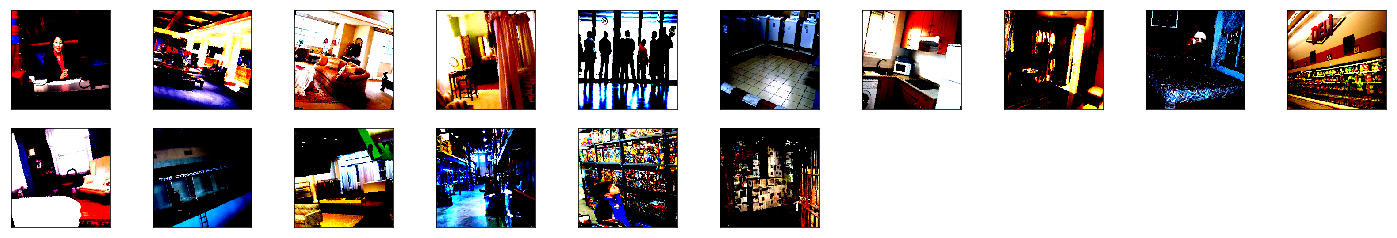

In [6]:
# Visualizing some sample data
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):                                             #Change the range according to your batch-size
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))

In [7]:
# check if CUDA / GPU is available, if unavaiable then turn it on from the right side panel under SETTINGS, also turn on the Internet
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 54504329.44it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
for param in model.parameters():
    param.requires_grad = False
num_filters = model.fc.in_features
model.fc = torch.nn.Linear(num_filters, 67)

In [10]:
device = torch.device("cuda" if train_on_gpu else "cpu")

# Loss function to be used
criterion = nn.CrossEntropyLoss()   # You can change this if needed

# Optimizer to be used, replace "your_model" with the name of your model and enter your learning rate in lr=0.001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
n_epochs = 10    #number of epochs, change this accordingly

for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Calculate Accuracy         
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * correct / total
    # Print Loss
    print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: <built-in function iter>. Loss: 3.230177879333496. Accuracy: 33
Iteration: <built-in function iter>. Loss: 2.5501012802124023. Accuracy: 44
Iteration: <built-in function iter>. Loss: 1.9220657348632812. Accuracy: 48
Iteration: <built-in function iter>. Loss: 1.9978984594345093. Accuracy: 53
Iteration: <built-in function iter>. Loss: 1.959620714187622. Accuracy: 56
Iteration: <built-in function iter>. Loss: 1.837522029876709. Accuracy: 59
Iteration: <built-in function iter>. Loss: 1.4489935636520386. Accuracy: 60
Iteration: <built-in function iter>. Loss: 1.5789347887039185. Accuracy: 62
Iteration: <built-in function iter>. Loss: 1.4976515769958496. Accuracy: 63
Iteration: <built-in function iter>. Loss: 1.675612211227417. Accuracy: 63


In [12]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [13]:
submission = pd.read_csv('../input/sample_sub.csv')
submission.head()

,Category,Id
0,0,fysglz.jpg
1,0,dyiwdi.jpg
2,0,blyymx.jpg
3,0,xkyygh.jpg
4,0,efobnp.jpg


In [14]:
#Loading test data to make predictions

testset = ImageDataset(csv_file = '../input/sample_sub.csv', root_dir = '../input/data/data/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=0)

In [16]:
submission.to_csv('submission.csv', index=False, encoding='utf-8')